In [23]:
def import_data(tickers, start, end, give = "R", adj_close = True, dividend = True):#read in stock data  
    """
    tickers: tickers to read 
    start, end: dates in datetime.datetime(2015,12,1) format
    give: return prices or returns 
    adj_close: use adjusted or unadjusted price
    dividend: include dividend?
    """
    
    if give=='D':
        adj_close=False
        dividend = True
    
    stocks = pd.DataFrame()
    if (adj_close == True):
        dividend = False
        stocks[tickers] = data.DataReader(tickers, 'yahoo', start, end)['Adj Close']
    else:
        stocks[tickers] = data.DataReader(tickers, 'yahoo', start, end)['Close']
            
        if (dividend == True): 
            stock_div = pd.DataFrame(index=stocks.index)
            for tick in tickers:
                stock_div[tick+' div'] = data.DataReader(tick, 'yahoo-dividends', start, end)["value"]
      
    just_stocks=stocks
    if (dividend == True):
        stocks = pd.concat([stocks,stock_div],axis=1)
        stocks = stocks.fillna(0)
        
    if(give == "R"):
        #Adding dividends to price appreciation on a daily percent return basis -useful for all analysis
        raw_returns=pd.DataFrame()
        for tick in tickers:
            if (dividend == True):
                raw_returns[tick] = stocks[tick].pct_change() + stocks[tick+' div']/stocks[tick] 
                #dividends are actually added on the day before they should be added but this error is neglegible
            else:
                raw_returns[tick] = stocks[tick].pct_change()
        returns=raw_returns[1:]
        return returns[np.isfinite(returns).all(1)]
        
    if(give == "P"):
        return just_stocks
    
    if(give=="D"):
        dividend = pd.DataFrame(np.array(stocks.iloc[:,len(just_stocks.columns):])/np.array(stocks.iloc[:,:len(just_stocks.columns)])).set_index(just_stocks.index)
        dividend.columns=just_stocks.columns
        return dividend

def calculate_posterior_mean(like_pop, prior_pop):
    mu0 = prior_pop.mean()
    w0 = prior_pop.std()
    dbar = like_pop.mean()
    w = like_pop.std()

    # Prior:
    prior = stats.norm(mu0, w0)
    # Likelihood:
    like = stats.norm(dbar, w)

    #computer posterior mean, std, distribution
    B = w**2/(w**2+w0**2)
    mu_s =dbar+B*(mu0-dbar)
    w_s = w*sqrt(1-B)
    posterior = stats.norm(mu_s, w_s)
    return mu_s



def mean_var_opt(posLB, posUB, t, tickers, increments_for_graph, Cov, muf, mean_vect):
    """
    posLB,posUB: upper and lower bounds for individual positions
    t: number to multiply expected returns by to make them yearly
    tickers: list of column names
    increments_for_graph: decreasing this number increases the number of portfolios calculated
    Cov: covariance of returns
    muf: should be a single value
    mean_vect: should be mean of dataframe

    """
    Cov = 2 * np.array(Cov)
    mean_vect = mean_vect * t
    muf  = muf * t
    m = len(tickers)

    from scipy.optimize import linprog
    #set equality constraints. I want my positions to sum to 1
    A_eq = np.array((1,)*m).reshape(1,-1)
    b_eq = [1]

    # set bounds on leverage. We can short but we can not go long
    bounds = np.vstack([(posLB,)*m, (posUB,)*m]).T

    #find min and max return
    min_rtn = mean_vect @ linprog(c=mean_vect, A_eq = A_eq, b_eq = b_eq, bounds=bounds).x
    max_rtn = mean_vect @ linprog(c=-mean_vect, A_eq = A_eq, b_eq = b_eq, bounds=bounds).x

    from qpsolvers import solve_qp
    muP = np.arange(min_rtn * .995,max_rtn * .995, increments_for_graph)
    sdP = np.zeros(len(muP))
    weights = np.zeros([len(muP),m])

    q_vec = np.zeros(m).reshape(-1,)
    G = np.zeros([m,m])
    h = np.zeros(m)
    A = np.vstack([np.array((1,)*m).reshape(1,-1),mean_vect])

    #calculate each optimized portfolio for each mean
    for i in range(len(muP)):
        b = np.array([1,muP[i]])
        weights[i] = solve_qp(P=Cov, q = q_vec, G=G, h=h, A=A, b=b, lb = bounds[:,0], ub = bounds[:,1])
        sdP[i] = np.sqrt(weights[i] @ (Cov/2) @ weights[i]) * np.sqrt(t)
    
    portfolios = pd.DataFrame({'Returns': muP, 'Volatility': sdP,})
    for counter, symbol in enumerate(tickers):
        portfolios[symbol+' weight'] = [w[counter] for w in weights]
    
    portfolios['Sharpe'] = (portfolios['Returns']-muf) / portfolios['Volatility'] #note using monthly returns and vol

    tangent = portfolios.iloc[[portfolios.Sharpe.argmax()]]
    min_var = portfolios.iloc[[portfolios.Volatility.argmin()]]
    efficient_portfolios = portfolios[portfolios['Returns'] >= min_var.Returns.values[0]-.02] #the .02 is arbitrary to see a bit below the min var port too

    return tangent, min_var, efficient_portfolios

In [2]:
#fix asssumption of means being normally distributed

In [3]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from norm_norm import *
from scipy import stats, integrate

In [28]:
start = datetime(2010,1,1)
end = datetime(2015,6,19)#when XLRE,XLC was introduced
tickers = ['XLV','XLI','XLB','XLK','XLU','XLY','XLP','XLF','XLE'] #XLRE, XLC
sectordata = import_data(tickers, start, end).resample("W").apply(lambda x: ((x + 1).cumprod()-1).last("D")) 

In [29]:
sectordata

,XLV,XLI,XLB,XLK,XLU,XLY,XLP,XLF,XLE
Date,,,,,,,,,
2010-01-10,0.005378,0.032839,0.026455,-0.009884,-0.011583,0.013000,-0.003749,0.036079,0.025336
2010-01-17,0.013845,-0.006154,-0.032073,-0.016493,0.006185,-0.013492,0.007527,-0.018397,-0.017247
2010-01-24,-0.017380,-0.042312,-0.064201,-0.044130,-0.035263,-0.032021,-0.017931,-0.050870,-0.049950
2010-01-31,-0.012003,-0.016523,-0.047107,-0.032318,-0.009725,-0.003791,-0.003423,0.000000,-0.031971
2010-02-07,-0.014386,-0.006574,0.011281,0.005248,-0.020657,-0.004842,-0.008397,-0.016925,-0.004771
...,...,...,...,...,...,...,...,...,...
2015-05-24,0.009696,-0.003677,-0.007572,0.006696,0.005641,0.004570,-0.010050,0.006478,-0.005826
2015-05-31,-0.000534,-0.019156,-0.009976,-0.005275,-0.001570,-0.008318,-0.009340,-0.010459,-0.022569
2015-06-07,-0.008006,0.000896,-0.011855,-0.009684,-0.040000,0.002883,-0.024595,0.007723,-0.009185


In [30]:
#calculated expected return array
def likelihood_n_posterior_mus(n, data, period=16): #period of 16 is 3 months with weekly data
    like_mus = np.zeros(len(data.columns))
    post_mus = np.zeros(len(data.columns))

    for ints,sector in enumerate(data.columns):
        likelihood_pop = np.array(data.iloc[n:n+period][sector])
        prior_pop = np.array(data.iloc[n:n+period])
        like_mus[ints] = likelihood_pop.mean() #normal mean opt 
        post_mus[ints] = calculate_posterior_mean(likelihood_pop,prior_pop) #bayesian means 
    return like_mus, post_mus

In [50]:
def tangent_rebalance(stocks, n, formation_period, port, weights, total,expt_rtn = 'like', Lower_bound=0, Upper_bound=1,annualizer = 52, muf = 0):
    likeMu, postMu = likelihood_n_posterior_mus(n, period=formation_period, data = stocks)
    cov = stocks[n-formation_period : n - 1].cov()
    if expt_rtn == 'like':
        tangent, min_var,eff_front = mean_var_opt(Lower_bound, Upper_bound, annualizer, stocks.columns, .01, cov, muf, likeMu)
    elif expt_rtn == 'not like':
        tangent, min_var,eff_front = mean_var_opt(Lower_bound, Upper_bound, annualizer, stocks.columns, .01, cov, muf, postMu)
    return np.array(tangent.iloc[:,2:-1])

In [51]:
def backtest(weights, col, dataf, expt_rtns = 'like', days_between_rebalance=1, show_weights=False, wealth = 1, RebalanceOffset=0, give='R',formation = 0): #cols allows users to backtest subsets of dataframe
    """
    weights: tells the function the number of assets. sets the starting weights and is the weights for constant rebalancing
    wealth: sets starting value
    RebalanceOffset: to offset day of rebalances by these values to provide information about rebalance timing luck
    give: return returns or prices
    formation: number of days covariance matrix is formed over
    
    """
    colin=[0]*len(weights)
    port=[0]*len(weights)
    worth=[wealth]

    for n in range(len(weights)):
        colin[n] = dataf.columns.get_loc(col[n])
        port[n]=wealth*weights[n]

    for n in range (formation,len(dataf)):
        port = np.multiply(port, np.array((1+dataf.iloc[n,colin])))
        end_of_day = sum(port)
        worth.append(end_of_day)
        
        if ((n + RebalanceOffset)% days_between_rebalance==0):        #rebalance
            #port=rebalance_func(dataf, n, formation, port, weights, sum(port))
            port=tangent_rebalance(dataf, n, formation, port, weights, expt_rtns)
            if show_weights == True:
                print(np.round(np.array(port/sum(port)),2))
                
    if (give=='R'):            
        p_rtn = pd.DataFrame(worth).pct_change()[1:].set_index(dataf.index[formation:])
        return(p_rtn)
    if (give=='P'):
        return(pd.DataFrame(worth[1:]).set_index(dataf.index[formation:]))

In [52]:
initial_weights = np.ones(len(sectordata.columns))/len(sectordata.columns)

#standard covariance 3month lookback for expted returns and covariance
likelihood = backtest(initial_weights, sectordata.columns, sectordata, formation = 16, expt_rtns = 'like')
posterior = backtest(initial_weights, sectordata.columns, sectordata, formation = 16, expt_rtns = 'not like')

In [53]:
comparisons = pd.concat([likelihood.rename({0:'like'},axis=1),posterior.rename({0:'post'},axis=1)], axis=1)

<AxesSubplot:xlabel='Date'>

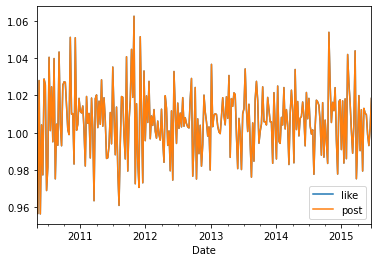

In [54]:
((comparisons+1).cumprod()).plot()

In [55]:
comparisons.corr()

,like,post
like,1.0,1.0
post,1.0,1.0


In [56]:
comparisons.mean()

like    0.00043
post    0.00043
dtype: float64

In [ ]:
#something wrong in my code? results are the same


In [ ]:
next do exponentially weighted covariance matrix